# Customer Attrition Model - Part 2
## Exploratory Data Analysis

# 2.0 Notebook Brief

This notebook consist of further analysis from the merged dataset obtained from IBM community. The IBM telco churn datasets are used as a part of customer attrition study. The dataset consists of merged files which includes, the demographics, churn status, services subscription, charges and revenue as a Q3 report. The datasets is localised in the California state only, with 7043 rows of fictional customer datasets for this study's purpose. 

In this notebook, we will observed exploratory data analysis, feature engineering and feature selection prior to clustering of datasets in the next notebook. 

Additional regression analysis were perform in a bonus notebook to indulge in the features affecting the total_revenue in this scenario. 

## 2.1 Problem Statement

In this study, we will first perform customer segmentation based on the Q3 datasets we obtained from IBM Business Analytics Community. In every company, the quintessential plan is often its retention plan. 

This study will also extends to predict the customer churn in the next three months from past data. The model accuracy will be assessed as overall prediction performance. The ROC AUC is used for further review the specificity and sensitivity on the model performance. To further apply for market deployment, additional time-series datasets will then verify the churning probability of customers. 

## 2.2 Introduction

> There is a big difference between a satisfied customer and a loyal customer - Shep Hyken


With spewing yet saturated competitions in the telecommunication industry, in order to stay ahead in the competition, customer satisfaction should always a the business driver with customer attrition as a goal.

Customer Attrition is also known as customer churn where customer ends the commercial relationship with the business. Customer lifetime value (CLTV) an important key metric to measure the health of business. Customer attrition is inevitable, but as business the goal is to reduce customer attrition. Churn rate is expressed as a rate that indicates the number of customers lost over a given period of time. With the cost of acquisition often greater than customer retention [(Customer Retention Strategy, 2016)](https://blog.exitbee.com/8-simple-customer-retention-strategies-to-decrease-your-churn-rate/), being able to identify why and when a customer is leaving, allows business to take on proactive approach and win the customer back. 

## 2.3 Data Imports

In [1]:
## FOR INSTALLATION OF LIBRARY THE FOLLOWING NEEDS TO BE INSTALLED FOR THE CODES TO RUN
# !pip install geopandas
# !pip install folium
# !pip install heatmapz

In [2]:
#import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for hypothesis testing
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

#for heatmap visualization
from heatmap import heatmap, corrplot

#for mapping
import geopandas as gpd
from shapely.geometry import Point
import folium 

In [3]:
#read merged dataset
telco = pd.read_csv('../data/telco_merged_data.csv')

#set display max 100
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

Upon several iteration, the following columns has been dropped as the entire dataset depict the same singular information.

1. `lat_long` , `country`, `state` and`quarter`.

Further columns were dropped as the collinearity of the information against existing columns.

2. `partner`, `device_protection_plan`,`premium_tech_support`, `tenure_in_months`

Churn Label is dropped as well as it reflects the customer status. 

3. `churn_label`

Identification of partner has collinearity with married status. Hence were dropped in the earlier stage. 

4. `partner`

### 2.3.1 Preliminary Data Cleaning and Feature Selection

In [4]:
#drop lat_long as longitude and latitude col is present
#drop country and states as all data from same location
#drop quarter as all data is in Q3 

#drop partner, drop protection plan, drop premium tech support
#drop churn label 
#drop tenure in months

telco = telco.drop(columns=['country','state','lat_long', 'quarter', 'partner', 'customer_id',
                            'device_protection_plan','premium_tech_support', 'churn_label', 'tenure_in_months'])

In [5]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges_y,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density
0,Male,78,No,Yes,No,No,0,Los Angeles,90022,34.023810,-118.156582,1,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,1,100,5433,Competitor offered more data,No,0,None,0.00,DSL,8,No,No,39.65,39.65,0.00,20,0.00,59.65,3,Churned,Competitor,15334
1,Female,74,No,Yes,Yes,Yes,1,Los Angeles,90063,34.044271,-118.185237,8,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),1,69,5302,Competitor made better offer,Yes,1,Offer E,48.85,Fiber Optic,17,No,Yes,80.65,633.30,0.00,0,390.80,1024.10,3,Churned,Competitor,17038
2,Male,71,No,Yes,No,Yes,3,Los Angeles,90065,34.108833,-118.229715,18,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,81,3179,Competitor made better offer,No,0,Offer D,11.33,Fiber Optic,52,Yes,Yes,95.45,1752.55,45.61,0,203.94,1910.88,2,Churned,Competitor,8625
3,Female,78,No,Yes,Yes,Yes,1,Inglewood,90303,33.936291,-118.332639,25,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1,88,5337,Limited range of services,Yes,1,Offer C,19.76,Fiber Optic,12,No,Yes,98.50,2514.50,13.43,0,494.00,2995.07,2,Churned,Dissatisfaction,11799
4,Female,80,No,Yes,Yes,Yes,1,Whittier,90602,33.972119,-118.020188,37,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1,67,2793,Extra data charges,Yes,1,Offer C,6.33,Fiber Optic,14,No,Yes,76.50,2868.15,0.00,0,234.21,3102.36,2,Churned,Price,6947


Columns are updated to binary information for simplicity in evaluation in its effect to churn rates.

In [6]:
#columns with Yes/No output to udpate to binary 
columns = ['under_30', 'senior_citizen', 'married', 'dependents',
           'phone_service','paperless_billing','referred_a_friend',
           'streaming_music','unlimited_data','online_security','online_backup', 
           'device_protection','tech_support','streaming_tv','streaming_movies','multiple_lines']

#replacement of values
telco[columns] = telco[columns].replace({'No': 0, 'Yes': 1,'No internet service': 0, 'No phone service':0})
telco['gender'] = telco['gender'].replace({'Male': 0,'Female': 1})

#create col for new_user 
telco['new_user'] = (telco['customer_status'] == 'Joined').astype(int)
 
#target value churned  = 1, stayed = 0, joined = 0 
telco['customer_status'] = telco['customer_status'].replace({'Churned': 1,'Stayed': 0, 'Joined':0})

#rename contract to num of months
# telco['contract'] = telco['contract'].replace({'Month-to-month': 1, 'Two year': 24, 'One year':12})


In [7]:
#null in churn cat and churn reason
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             7043 non-null   int64  
 1   age                                7043 non-null   int64  
 2   under_30                           7043 non-null   int64  
 3   senior_citizen                     7043 non-null   int64  
 4   married                            7043 non-null   int64  
 5   dependents                         7043 non-null   int64  
 6   number_of_dependents               7043 non-null   int64  
 7   city                               7043 non-null   object 
 8   zip_code                           7043 non-null   int64  
 9   latitude                           7043 non-null   float64
 10  longitude                          7043 non-null   float64
 11  tenure_months                      7043 non-null   int64

In [8]:
# managing isnull values as N/A for churn_category and churn_reason
telco.churn_reason = telco.churn_reason.fillna('NA')
telco.churn_category = telco.churn_category.fillna('NA')

In [9]:
#minor rename of total charges for consistency
telco = telco.rename(columns={'total_charges_y':'total_charges'})

In [10]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             7043 non-null   int64  
 1   age                                7043 non-null   int64  
 2   under_30                           7043 non-null   int64  
 3   senior_citizen                     7043 non-null   int64  
 4   married                            7043 non-null   int64  
 5   dependents                         7043 non-null   int64  
 6   number_of_dependents               7043 non-null   int64  
 7   city                               7043 non-null   object 
 8   zip_code                           7043 non-null   int64  
 9   latitude                           7043 non-null   float64
 10  longitude                          7043 non-null   float64
 11  tenure_months                      7043 non-null   int64

In [11]:
#export regression analysis and clustering
telco.to_csv('../data/telco_cleaned_final.csv',index=False)

## 2.4 Demographics Exploration

26% of the datasets contains churn customers whereas balance 74% consists of current customers and newly joined customers in Q3. As preliminary exploration, the features that were converted to binary columns are evaluated on the mean against the customer status. 

In [12]:
telco.customer_status.value_counts(normalize=True)

0    0.73463
1    0.26537
Name: customer_status, dtype: float64

In [13]:
#group and check relationship between age range
age_group = telco.groupby(by=['under_30','senior_citizen']).agg({'age':['mean' ,lambda x : x.count()/telco.shape[0]], 
                                                                 'customer_status': lambda x : x.sum()/telco.shape[0],
                                                                 'gender': 'mean',
                                                                'married': 'mean'}).rename(columns={'<lambda_0>':'perc_age','<lambda>':'churn_rate'})
age_group.reset_index()

under_30 senior_citizen        age           customer_status    gender  \
                                mean  perc_age      churn_rate      mean   
0        0              0  46.963778  0.638932        0.154622  0.493778   
1        0              1  72.457093  0.162147        0.067585  0.497373   
2        1              0  23.900785  0.198921        0.043163  0.498216   

    married  
       mean  
0  0.473556  
1  0.501751  
2  0.498216

The customer group age consist of range 19 - 29, 30 - 64, and 65 - 80. 
The distribution of the entire customer-based in the Q3, there is 64% between 30-64, 16% and 20% for senior citizen and under 30 respectively.

Highest churn rate for age group 30-64 years at least twice more than under 30 and senior citizen. Gender and marriage statuses does not indicate specific majority in any age range.

## 2.5 Categorical Data Exploration

In [14]:
#group binary columns 
binary_tel = telco.select_dtypes(include='number')
#group columns by customer status ( 1: Churn or 0: Stayed ) 
binary_tel = binary_tel.groupby(by='customer_status').agg('mean')
binary_tel

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,churn_value,churn_score,cltv,referred_a_friend,number_of_referrals,avg_monthly_long_distance_charges,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,pop_density,new_user
customer_status,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.492656,45.344414,0.212022,0.128721,0.528218,0.293970,0.595284,93518.212215,36.287436,-119.804838,37.569965,0.901044,0.409934,0.333204,0.368380,0.362775,0.335137,0.365868,0.369927,0.535562,0.0,50.098183,4490.921337,0.502126,2.468690,22.883572,19.915733,0.340162,0.626788,61.265124,2550.792103,2.122279,6.752996,862.952107,3418.374927,3.789911,3506.372826,0.087746
1,0.502408,49.735688,0.162654,0.254682,0.357945,0.056715,0.118245,93532.352595,36.268614,-119.782388,17.979133,0.909042,0.454789,0.157838,0.279829,0.291600,0.165864,0.435527,0.437667,0.749064,1.0,82.510433,4149.414660,0.333868,0.521134,23.167635,22.175495,0.389513,0.803638,74.441332,1531.796094,1.518983,7.158909,433.917549,1971.353569,1.736223,3690.815944,0.000000


### 2.5.1 Binary Features

In [15]:
#columns with binary features

less_one = ['gender', 'under_30', 'senior_citizen', 'married', 'dependents',
       'number_of_dependents', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'referred_a_friend', 'streaming_music',
       'unlimited_data']

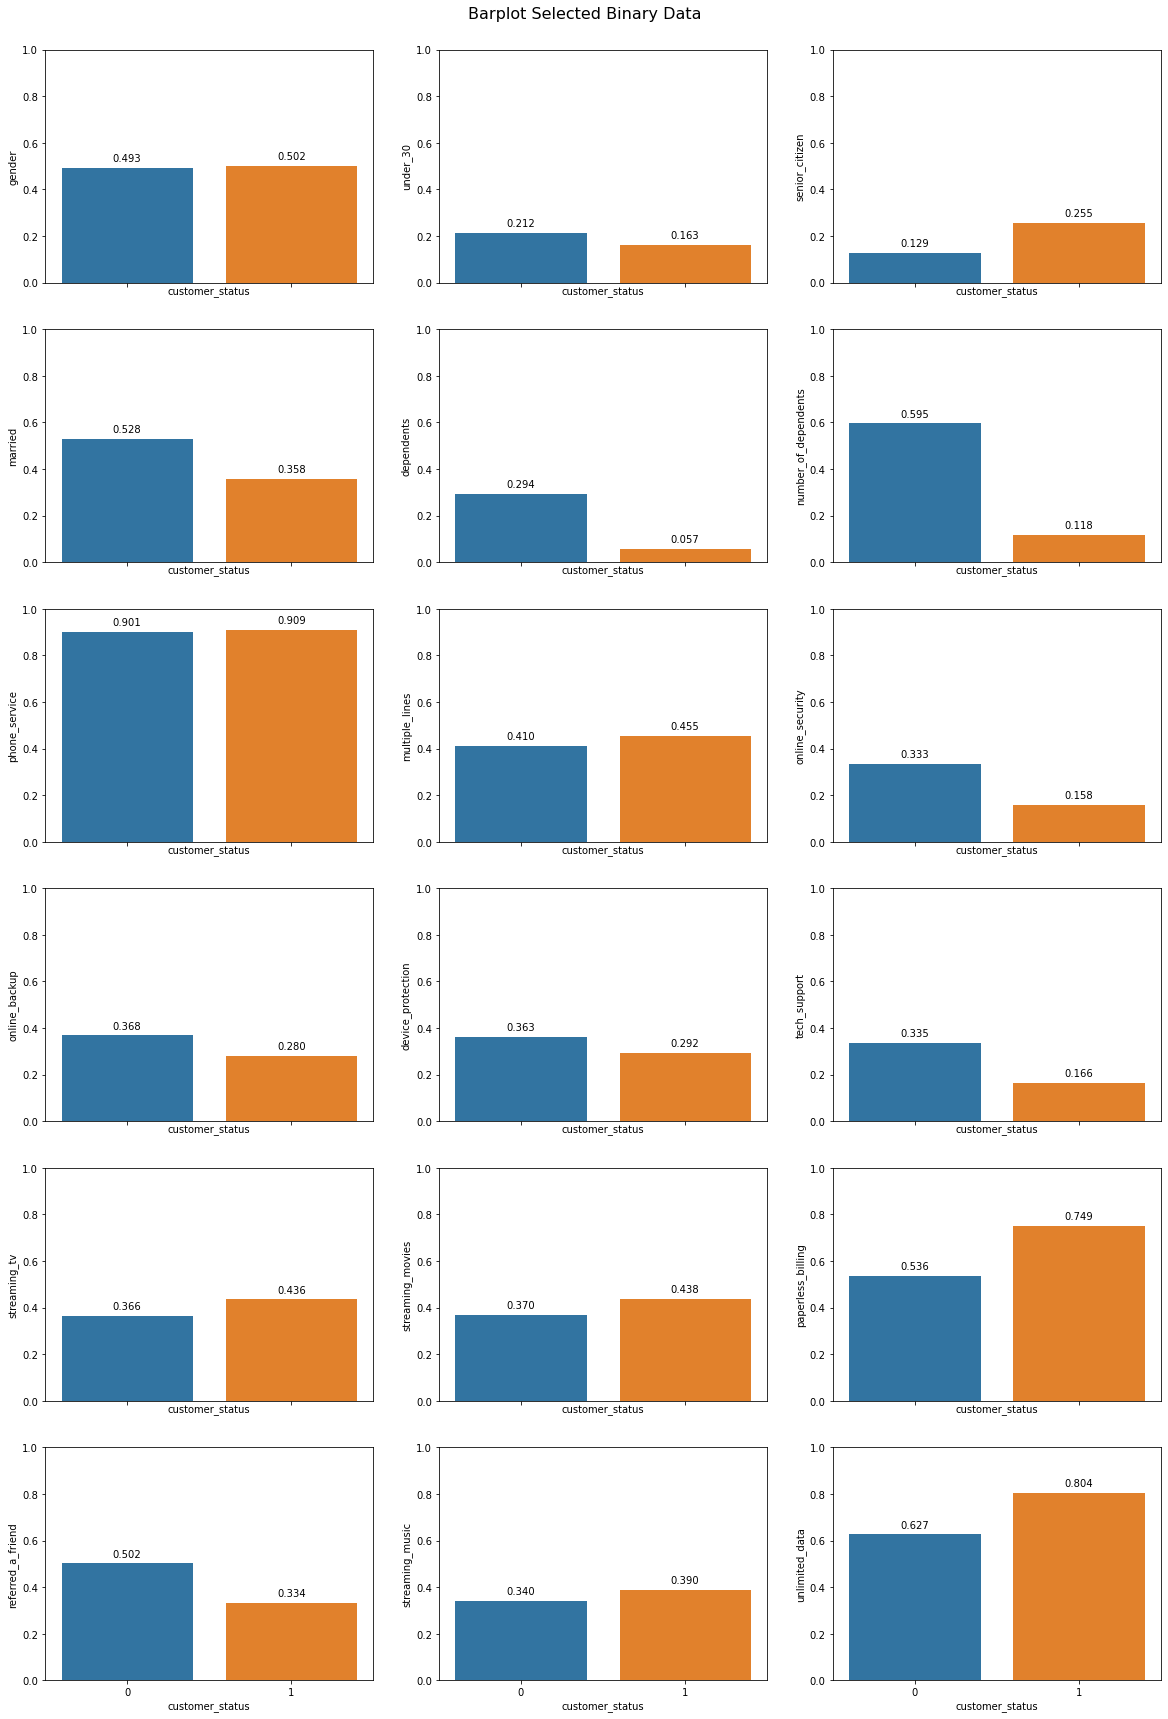

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30), sharex=True)
ax = ax.flatten()

for idx, col in enumerate(less_one):
    graph = sns.barplot(data=binary_tel, x=binary_tel.index, y=col, ax=ax[idx],)
    ax[idx].set_ylim(ymin=0.0, ymax=1.0)
    
#annotation
    for p in graph.patches:
        graph.annotate('{:.3f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()+0.02),
                    ha='center', va='bottom',
                   color= 'black')
        
plt.suptitle(t='Barplot Selected Binary Data',x=0.5, y = .9, fontsize=16);
plt.savefig('../images/barplot_binary.png')
plt.show()

*Interpretation:*

1. Several features does not indicate a strong seperation for instance, `gender`, `under_30`, `phone_service`, `device_protection`, `streaming_movies` and `multiple_lines`.

2. Demographics features indicates that `senior_citizen` churn rate is higher and vice versa for `married` couples. This comes naturally with possibility that married couplrs have higher commitment.

3. Add-on services like `device_protection`, `tech_support`, `online_backup`, `online_security` shows a lower churn rate compared to not having the additional services subscriptions. This infer a possible aid with having users to subscribe to additional packages. 

4. Whilst the monetary features that indicates charges do share a higher churn rate like `streaming_music`, `streaming_movies`,`unlimited_data`, `streaming_tv` and `unlimited_data`.

### 2.5.2 Categorical Features

Other features are generally categorical hence will be reviewed using heatmap to see the correlation coefficient. Ideally, the assumption are that the features have a linear relationship to the `customer_status` however, collinearity between each features. 

Statues like `churn_reason` and `city` is removed from this correlation analysis as it does has extensive unique counts that will affect the values of correlation. These features shall be evaluated separately.

In [17]:
#group categorical columns 
cat_tel = telco.select_dtypes(exclude='number')
#group columns by customer status ( 1: Churn or 0: Stayed ) 
#drop churn statuses and city
cat_tel = cat_tel.drop(columns=['churn_reason','churn_category', 'city'])

In [18]:
#merge bool and cat together
cat_tel = pd.concat([cat_tel,telco[less_one], telco['customer_status']], axis=1)

In [19]:
cat_tel.head()

,internet_service,contract,payment_method,offer,internet_type,gender,under_30,senior_citizen,married,dependents,number_of_dependents,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,referred_a_friend,streaming_music,unlimited_data,customer_status
0,DSL,Month-to-month,Electronic check,None,DSL,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1
1,Fiber optic,Month-to-month,Credit card (automatic),Offer E,Fiber Optic,1,0,1,1,1,1,1,1,0,1,0,0,0,0,1,1,0,1,1
2,Fiber optic,Month-to-month,Electronic check,Offer D,Fiber Optic,0,0,1,0,1,3,1,1,0,0,0,0,1,1,1,0,1,1,1
3,Fiber optic,Month-to-month,Electronic check,Offer C,Fiber Optic,1,0,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,1
4,Fiber optic,Month-to-month,Electronic check,Offer C,Fiber Optic,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1,1


#### 2.5.1 Cramér's V Measurement

As we are dealing with categorical features, chi squared test are used to evaluate the significance of he features. 

We will first provide a function for Cramér’s V test. Cramér's V is an **effect size** measurement for the chi-square test of independence. It is evaluated in number between 0 and 1 that indicates how strongly two categorical variables are associated.


\begin{align*}
V = \sqrt\frac{\chi^2/n}{min(k-1, r-1)}
\end{align*}

where <br>
$\chi^2$ = Pearson chi squared test<br>
$n$ = total observation<br>
$k$ = number of columns<br>
$r$ = number of rows<br>

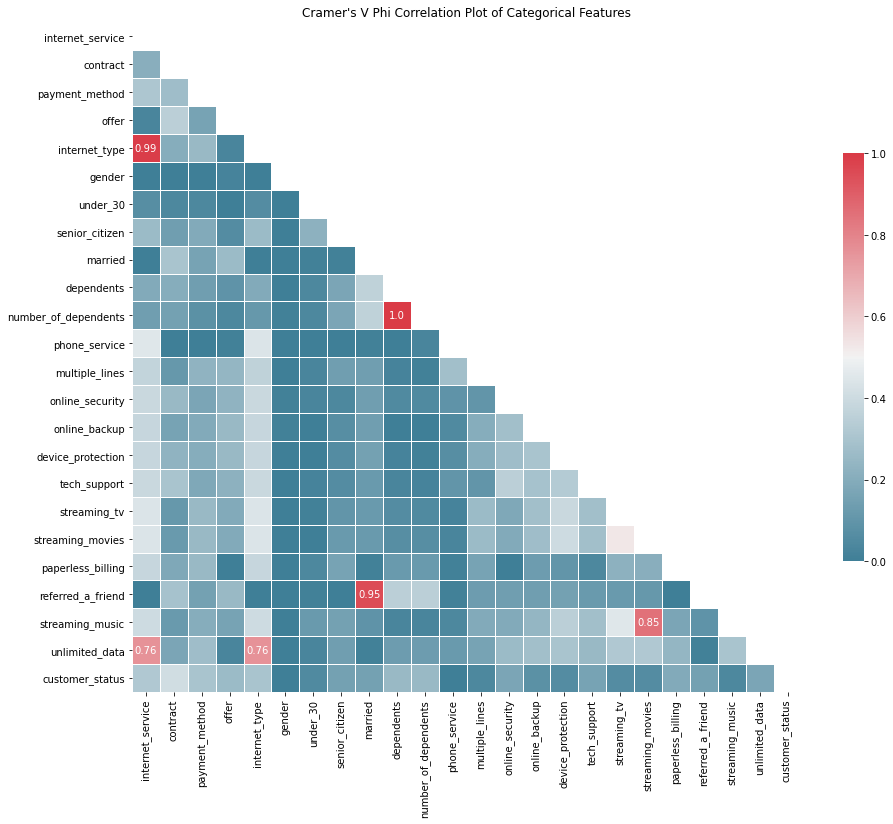

In [20]:
#cramers formula : using chi2 to measure strength of relationship
def cramers_v(x, y):
    #create cross tab
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0] #chi2
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


# Create a correlation dataframe
corrs = dict()
categorical = cat_tel
for out_col in categorical.columns:
    col_corr = dict()
    for in_col in categorical.columns:
        col_corr[in_col] = cramers_v(categorical[in_col], categorical[out_col])
    corrs[out_col] = col_corr
corrs = pd.DataFrame(corrs)

# Plotting correlation heatmap 
corr = round(corrs, 2)
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(225,10,as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype= bool))
labels = corr.applymap(lambda v: v if (v > 0.55) else '')

sns.heatmap(corr, square=True, annot=labels, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5}, fmt='.2', vmin=0, vmax=1)
plt.title("Cramer's V Phi Correlation Plot of Categorical Features")
plt.savefig('../images/heatmap_categorical.png')
plt.show()

*Interpretation:*
*The correlation effect between several features are prominent,hence important to be removed prior to modelling for prediction.*

1. `internet_type` and `internet_service` against `unlimited_data`

In [21]:
telco.internet_type.value_counts(normalize=True)

Fiber Optic    0.430924
DSL            0.234559
None           0.216669
Cable          0.117848
Name: internet_type, dtype: float64

In [22]:
#overview on the internet type users and internet service users overlap
pd.crosstab(index=telco.internet_service,columns=telco.internet_type)

internet_type,Cable,DSL,Fiber Optic,None
internet_service,,,,
DSL,769,1652,0,0
Fiber optic,61,0,3035,0
No,0,0,0,1526


In [23]:
pd.crosstab(index=telco.unlimited_data,columns=telco.internet_type)

internet_type,Cable,DSL,Fiber Optic,None
unlimited_data,,,,
0,115,238,419,1526
1,715,1414,2616,0


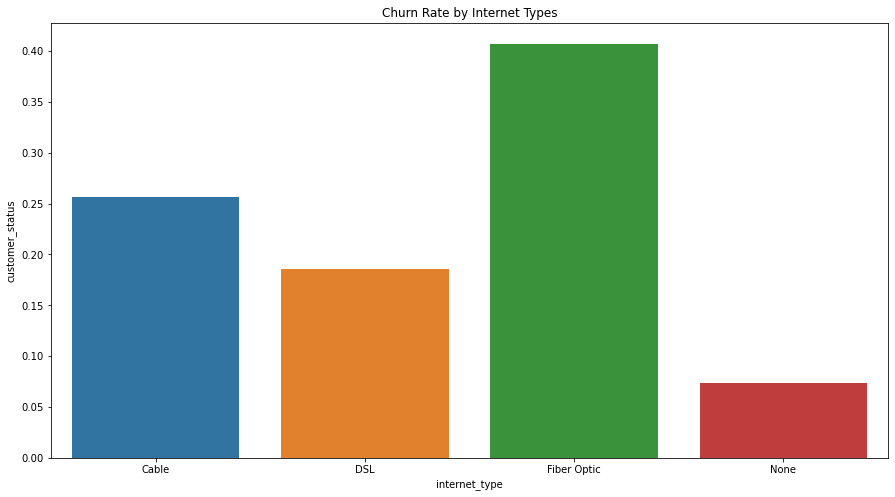

In [24]:
#by churn rate against internet type
plt.figure(figsize=(15,8))
sns.barplot(data=telco.groupby('internet_type').mean()['customer_status'].reset_index(),
            x='internet_type', y='customer_status')
plt.title('Churn Rate by Internet Types')
plt.savefig('../images/churn_by_internettype.png')
plt.show()

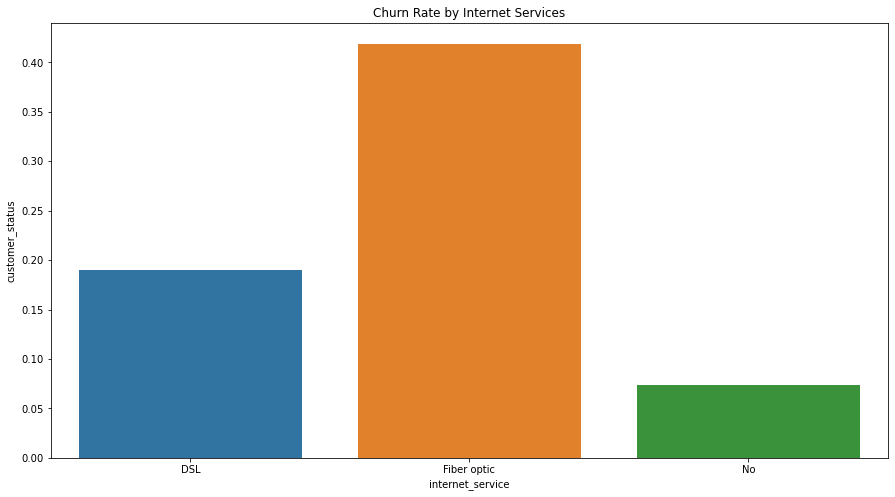

In [25]:
#by churn rate against internet service
plt.figure(figsize=(15,8))
sns.barplot(data=telco.groupby('internet_service').mean()['customer_status'].reset_index(),
            x='internet_service', y='customer_status')
plt.title('Churn Rate by Internet Services')
plt.show()

The usage of `internet_type` are correlated to `internet_service`. This is often driven with the changes offered by telecommunications company in ensuring the services provided are compatible with the hardware in order to deliver expected performance. 

The majority users has switched to fibre optic services as it promotes higher bandwidth and speed whereas old internet types like DSL and cables are still interchangeable for use as the inexpensive option [(NerdWallet, 2017)](https://www.nerdwallet.com/article/utilities/understanding-difference-dsl-cable-fiberoptic-internet-service). Nonetheless the indication that highet churn rate for fibre optic is likely due to competitions rather than the ineffectiveness of fibre optic itself. This can be further investigated from the churn reasons. 


With this information, we will remove `internet_type` as the services will reflect the offers subscribed by the users.

2. `number_of_dependents` and `dependents`

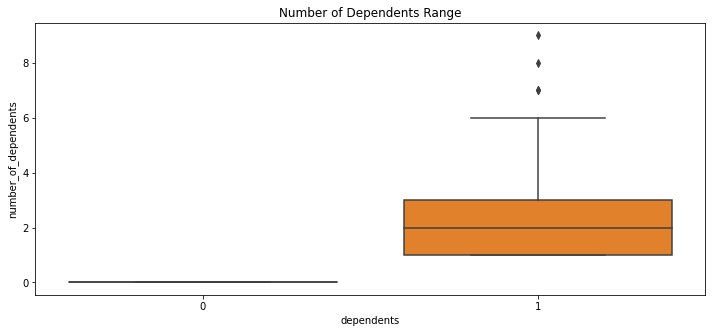

In [26]:
plt.figure(figsize=(12,5))
sns.boxplot(data=telco, y='number_of_dependents',x='dependents')
plt.title('Number of Dependents Range')
plt.savefig('../images/number_of_dependent.png')
plt.show()

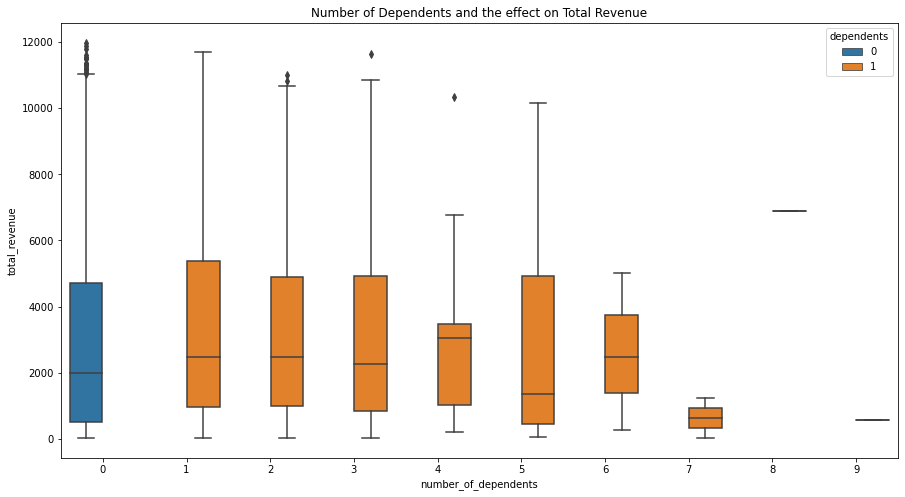

In [27]:
#dependents with num on the revenue
plt.figure(figsize=(15,8))
sns.boxplot(data=telco, x='number_of_dependents', y='total_revenue', hue='dependents')
plt.title('Number of Dependents and the effect on Total Revenue')
plt.savefig('../images/num_of_dependent_on_rev.png')
plt.show()

*Interpretation: The impact on the dependent counts does not have proportionally linear relationship to the total revenue, indicating the offers provided by telco company has a fixed package with as long as users signed up for at least with a partner.*

*This suggests the strategy for customer acquisition via family members has a ceiling to the range of revenue drive. Between 1 to 4 family members package is indication of value-for-money package. For families larger than 4 users would refute the customer acquisition cost as the return of investment (ROI) per user is lower for larger families.*

As `number_of_dependents` carries more information and its impact on the business, it will be retained for use in the modelling. 

3. `married` and `referred_a_friend`

In [28]:
#married that has referred a friend 
telco[telco.married==True].referred_a_friend.value_counts(normalize=True)

1    0.94709
0    0.05291
Name: referred_a_friend, dtype: float64

Looking into the relationship between `married` feature and havign `referred_a_friend`, 95% married partner made a reference. The hypothesis that that married partner are often the referred friend.

4. `streaming_movies` and `streaming_music`

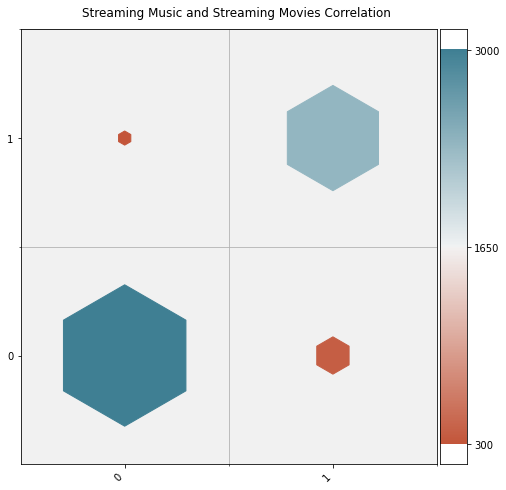

In [55]:
#plot viz for heatmap
palette = sns.diverging_palette(20, 220, n=256)
plot_df = telco.copy()
plot_df['count'] = np.ones(len(telco))
g = plot_df.groupby(['streaming_movies', 'streaming_music']).count()[['count']].reset_index()
plt.figure(figsize=(8, 8))
heatmap(
    x=g['streaming_movies'],
    y=g['streaming_music'],
    color=g['count'],
    size=g['count'],
    marker='h',
    size_scale=20000,
    palette = palette,
    color_range = (300, 3000),
    
)

plt.suptitle('Streaming Music and Streaming Movies Correlation', y=0.92)
plt.savefig('../images/music_vs_movie_corr.png')
plt.show()

The collinear correlation between `streaming_music` and `streaming_movies` are strong indicating package offered are tied where both are offered hand-in-hand but not exclusively.

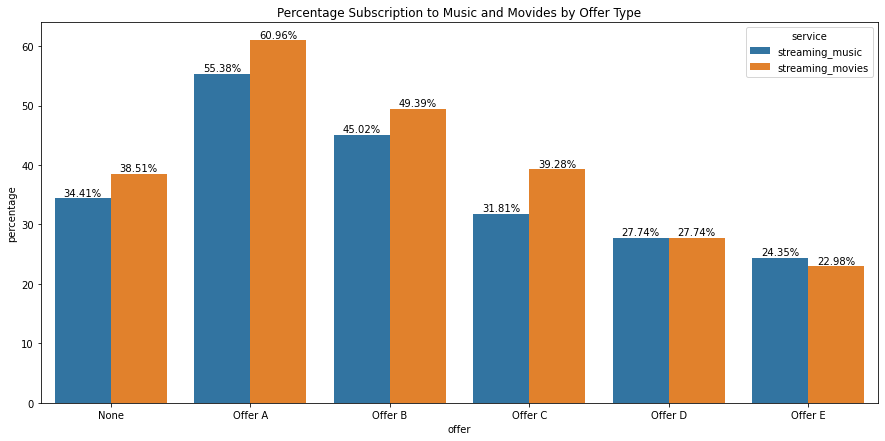

In [30]:
plot_df = telco.groupby('offer').agg('mean')[['streaming_music','streaming_movies']] * 100
plot_df = pd.melt(plot_df.reset_index(), id_vars='offer', var_name='service', value_name='percentage')

plt.figure(figsize=(15,7))
graph = sns.barplot(data=plot_df, x='offer', y='percentage', hue='service')
#annotation
for p in graph.patches:
    graph.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+0.1),
                    ha='center', va='bottom',
                   color= 'black')

plt.title('Percentage Subscription to Music and Movies by Offer Type')
plt.savefig('../images/music_vs_movie_by_offer.png')
plt.show()

*Interpretation: `streaming_movies` is almost inclusive of `streaming_music` subscription. Only Offer E has higher music subscription users compared to movies subscription.*

#### 2.5.2 Variance Inflation Factor (VIF)

In order of comparison of colinearity features, Variance Inflation Factor (VIF) is used as an feature selection method. 

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. VIF score of an independent variable represents how well the variable is explained by other independent variables.

For VIF above 5, multicolinearity is likely present and variables will be reviewed to be dropped. 
The selection process is an iterative move. Ideally, as variables are dropped the other variables factor will also be reduced.

In [31]:
#columns for VIF investigation
X=telco[['unlimited_data','number_of_dependents','dependents','married','referred_a_friend','streaming_music','streaming_movies']]

In [32]:
#create df to vif 
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [33]:
#initial VIF scores
vif

,VIF Factor,features
0,2.069243,unlimited_data
1,5.861559,number_of_dependents
2,6.331726,dependents
3,19.886032,married
4,18.906913,referred_a_friend
5,5.564450,streaming_music
6,6.019752,streaming_movies


In [34]:
#final vif scores after feature selection
X = X.drop(columns=['dependents','referred_a_friend','streaming_movies'])
vif = pd.DataFrame()

vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.983022,unlimited_data
1,1.358783,number_of_dependents
2,1.898546,married
3,1.683007,streaming_music


Based on the VIF scores, the collinear columns shall be dropped prior to modelling stage such as `dependents`, `referred_a_friend`, and `streaming_movies`. Dropping the columns has largely reduce the overall VIF on other features and this will allow more room for the equal weights in prediction model.

## 2.6 Numerical Data Exploration

Numerical features are evaluated as follow with disregard to the `new_user` and `churn_value` scores.

In [35]:
#numerical cols larger than 1.0
num_col = binary_tel.columns[~binary_tel.columns.isin(less_one)]
num_col = num_col.drop(['zip_code','latitude', 'longitude', 'churn_value','new_user'])
#columns
num_col

Index(['age', 'tenure_months', 'churn_score', 'cltv', 'number_of_referrals',
       'avg_monthly_long_distance_charges', 'avg_monthly_gb_download',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'satisfaction_score', 'pop_density'],
      dtype='object')

In [36]:
telco[num_col].head()

,age,tenure_months,churn_score,cltv,number_of_referrals,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,pop_density
0,78,1,100,5433,0,0.00,8,39.65,39.65,0.00,20,0.00,59.65,3,15334
1,74,8,69,5302,1,48.85,17,80.65,633.30,0.00,0,390.80,1024.10,3,17038
2,71,18,81,3179,0,11.33,52,95.45,1752.55,45.61,0,203.94,1910.88,2,8625
3,78,25,88,5337,1,19.76,12,98.50,2514.50,13.43,0,494.00,2995.07,2,11799
4,80,37,67,2793,1,6.33,14,76.50,2868.15,0.00,0,234.21,3102.36,2,6947


### 2.6.1 Pearsonr Coefficient Correlation

Significance of the coefficient correlation of the numerical features are explored in the following. The coefficient is given between -1 to 1, where 0 indicates no correlation. 

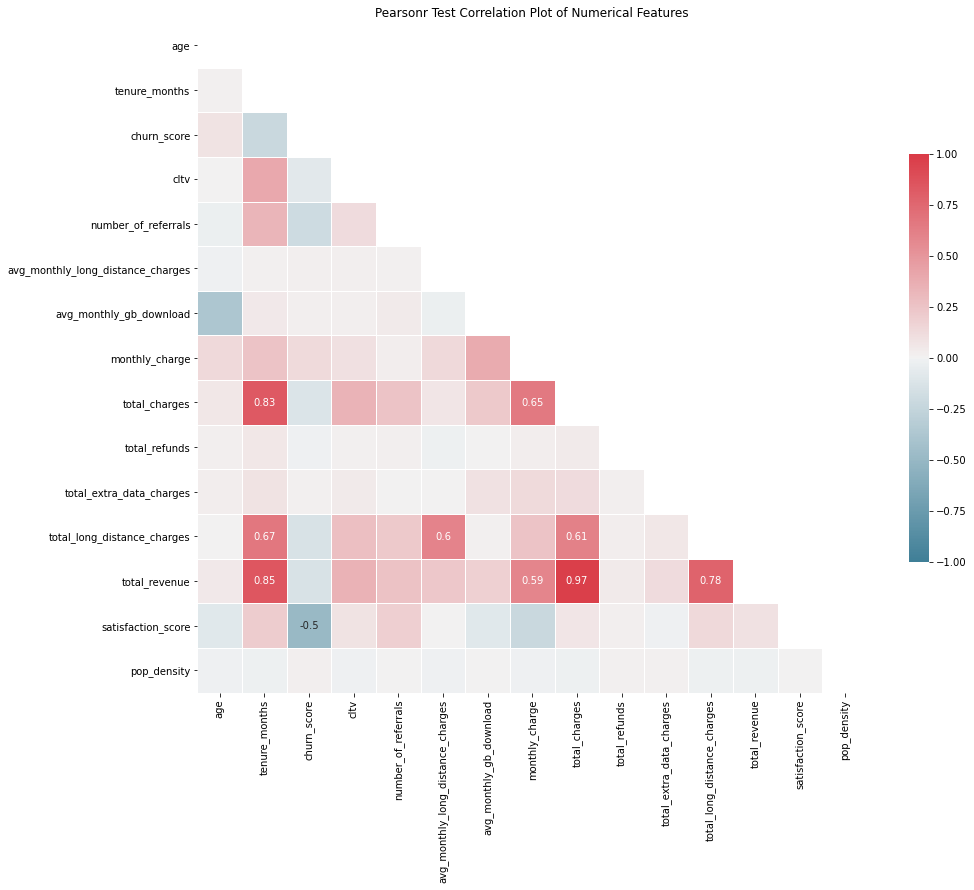

In [37]:
# Plotting correlation heatmap 
corr = round(telco[num_col].corr(), 2)
plt.figure(figsize=(15,15))

#annotation limits
labels = corr.applymap(lambda v: v if (v > 0.45) | (v < -0.45) else '')
#cmap palette
cmap = sns.diverging_palette(225,10,as_cmap=True)
#mask palette 
mask = np.triu(np.ones_like(corr, dtype= bool))

sns.heatmap(corr, square=True, annot=labels, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5}, fmt='.2', vmin=-1, vmax=1)

plt.title('Pearsonr Test Correlation Plot of Numerical Features')
plt.savefig('../images/heatmap_numerical.png')
plt.show()

*Interpretation:*

1. `churn_score` and `satisfaction_score` are colinear as the churn scores are indication of tendency to churn, with higher churn score evaluated from the low satisfaction scores. 

2.  `total_revenue` against `monthly_charge`,`total_charges`, `avg_monthly_long_distance_charges`, `total_long_distance_charges`, `tenure_months` are highly correlated in the in alternate regression model study. More details can be found in notebook 06 on the coefficient that drives the total revenue calculation. 

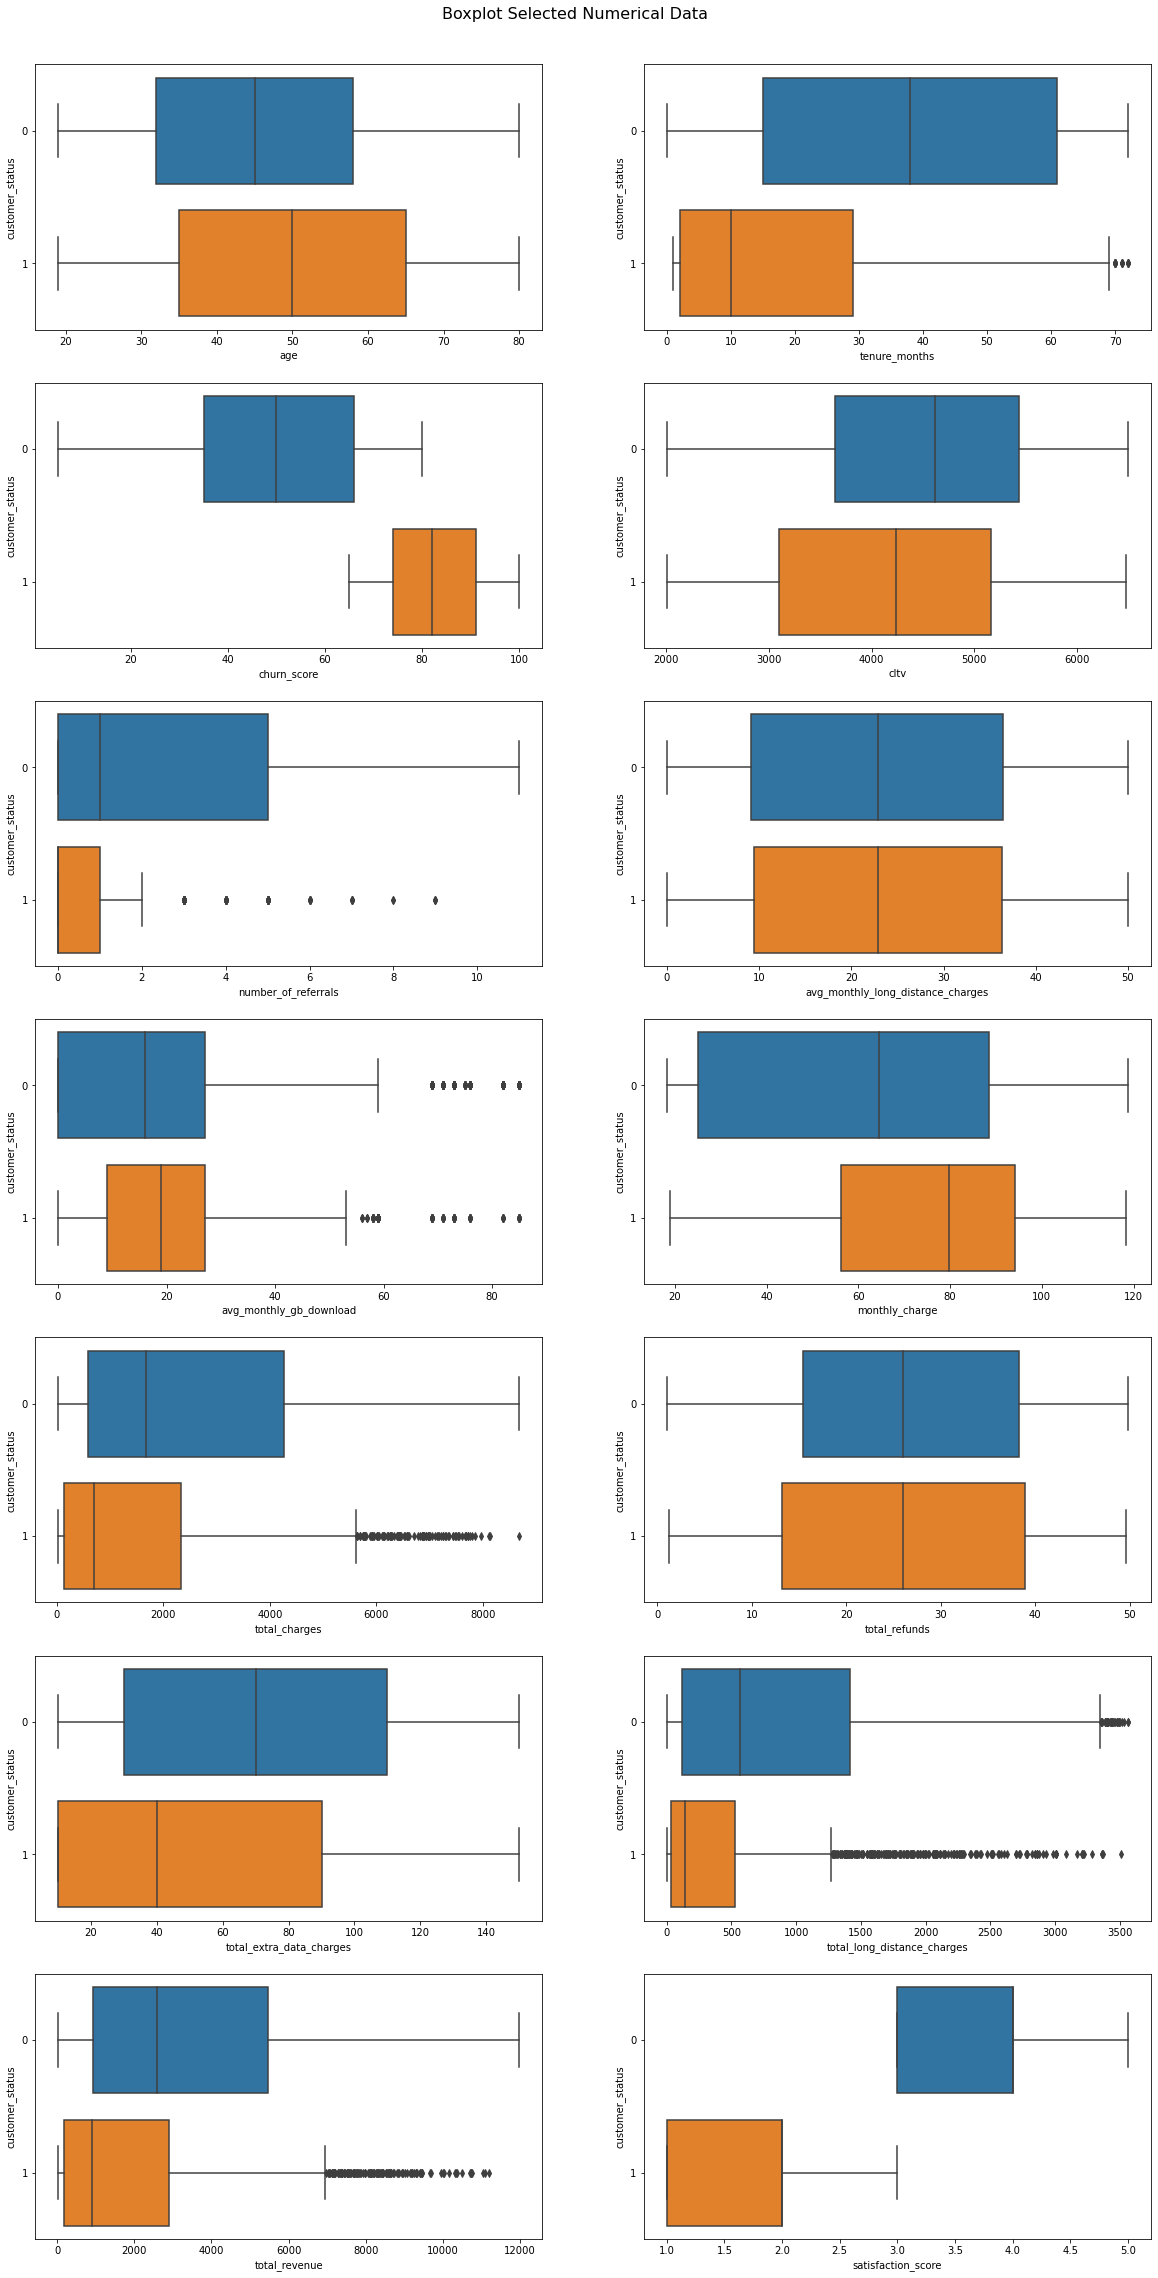

In [38]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(20,40))
ax = ax.flatten()

for idx, col in enumerate(num_col):
    if idx == 14:
        pass
    #for refund col removing 0
    elif idx == 9:
        sns.boxplot(data=telco[telco['total_refunds']>0], x='total_refunds', y='customer_status', 
                    orient='h', ax=ax[9])
        
    #for extra data charges col removing 0
    elif idx == 10:
        sns.boxplot(data=telco[telco['total_extra_data_charges']>0], x='total_extra_data_charges', 
                    y='customer_status', orient='h', ax=ax[10])
    else:
        sns.boxplot(data=telco, y=telco.customer_status, x=col, ax=ax[idx], orient='h')

plt.suptitle(t='Boxplot Selected Numerical Data',x=0.5, y = .9, fontsize=16);
plt.savefig('../images/boxplot_numerical.png')
plt.show()

*Interpretation:*

1. `tenure_months` often ends around 30 months from churned customers

2. `churn_score` above 65 with `satisfaction_score` below 3.0 are the cut off point of strong indication of churn tendency of customers.

3. Higher `number_of_referrals` are often from loyal customers with faith in the service and products. 

4. Churned customers are price-sensitive where the price related features like `total_long_distance_charges` and `total_extra_data_charges` are at a lower mean price yet has also decided to switch. More exploration needed to review if this correlates to the churn reasons. 

## 2.7 Other Feature EDA

In [39]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,zip_code,latitude,longitude,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user
0,0,78,0,1,0,0,0,Los Angeles,90022,34.023810,-118.156582,1,0,0,DSL,0,0,1,0,0,1,Month-to-month,1,Electronic check,1,100,5433,Competitor offered more data,0,0,None,0.00,DSL,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,Competitor,15334,0
1,1,74,0,1,1,1,1,Los Angeles,90063,34.044271,-118.185237,8,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Credit card (automatic),1,69,5302,Competitor made better offer,1,1,Offer E,48.85,Fiber Optic,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,Competitor,17038,0
2,0,71,0,1,0,1,3,Los Angeles,90065,34.108833,-118.229715,18,1,1,Fiber optic,0,0,0,0,1,1,Month-to-month,1,Electronic check,1,81,3179,Competitor made better offer,0,0,Offer D,11.33,Fiber Optic,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,Competitor,8625,0
3,1,78,0,1,1,1,1,Inglewood,90303,33.936291,-118.332639,25,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,1,88,5337,Limited range of services,1,1,Offer C,19.76,Fiber Optic,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,Dissatisfaction,11799,0
4,1,80,0,1,1,1,1,Whittier,90602,33.972119,-118.020188,37,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,1,67,2793,Extra data charges,1,1,Offer C,6.33,Fiber Optic,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,Price,6947,0


### 2.7.1 New User

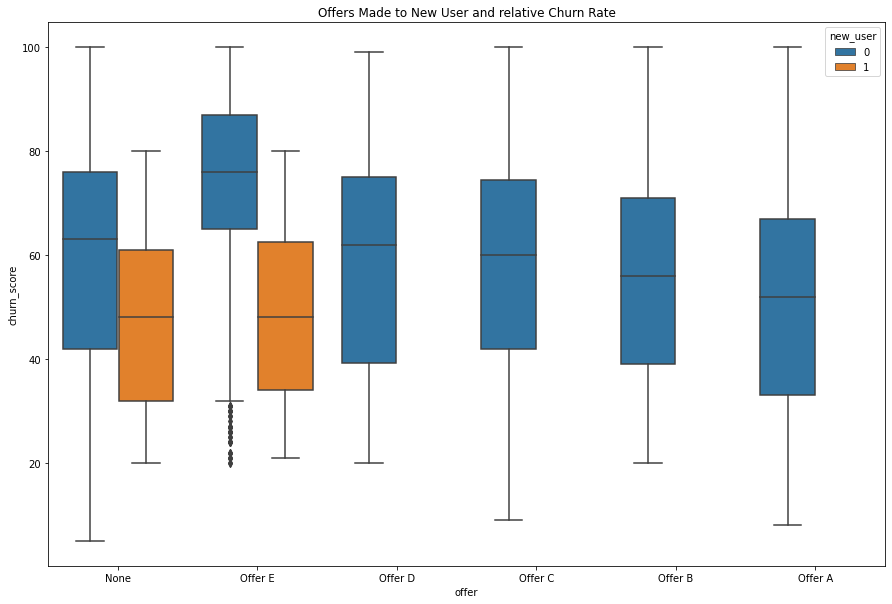

In [40]:
#churn rate on new user based on offer made
plt.figure(figsize=(15,10))
sns.boxplot(data=telco, x='offer', y='churn_score',hue='new_user')
plt.title('Offers Made to New User and Relative Churn Rate')
plt.savefig('../images/new_user_offer_churnrate.png')
plt.show()

*Interpretation: The offers made available for new users are Offer E only. It suggests either the previous offers were made invalid, or other offers were not feasible for the customers today. Nonetheless, Offer E has the highest churn score in the population.*

### 2.7.2 Contract

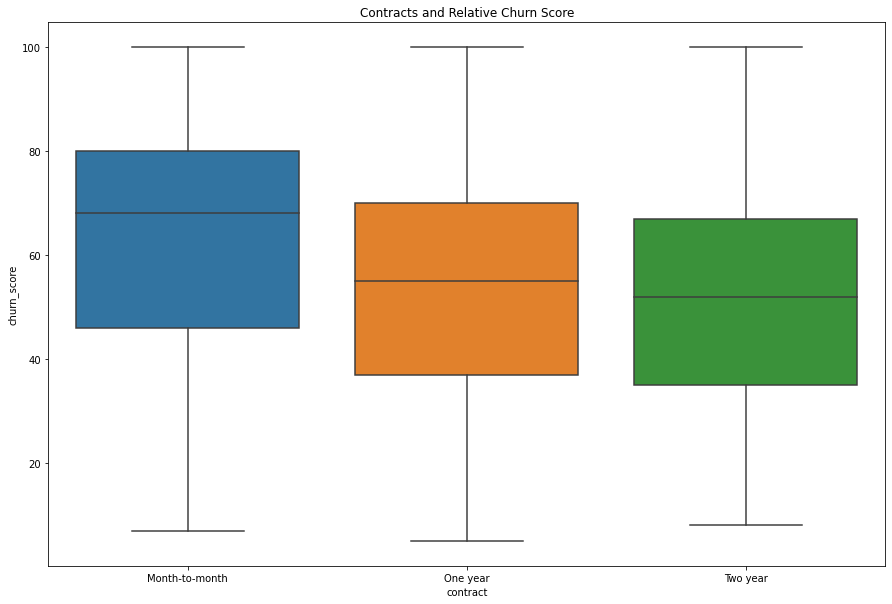

In [41]:
plt.figure(figsize=(15,10))
sns.boxplot(data=telco, x='contract', y='churn_score')
plt.title('Contracts and Relative Churn Score')
plt.savefig('../images/contract_churn_score.png')
plt.show()

*Interpretation: Month-to-month contract users are regarded with a higher churn score, as this offers more flexibility to change telco company.*

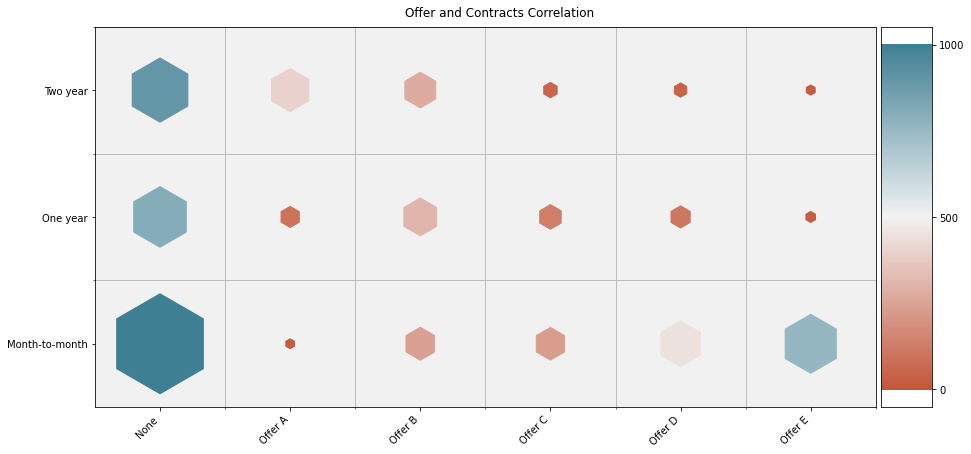

In [42]:
#plot viz for heatmap
palette = sns.diverging_palette(20, 220, n=256)
plot_df = telco.copy()
plot_df['count'] = np.ones(len(telco))
g = plot_df.groupby(['offer', 'contract']).count()[['count']].reset_index()
plt.figure(figsize=(15, 7))
heatmap(
    x=g['offer'],
    y=g['contract'],
    color=g['count'],
    size=g['count'],
    marker='h',
    size_scale=10000,
    palette = palette,
    color_range = (0, 1000),
    
)

plt.suptitle('Offer and Contracts Correlation', y=0.92)
plt.savefig('../images/offer_contract_corr.png')
plt.show()

*Interpretation: Most users prefer telco packages with offers and would sign to a month-to-month basis. While for offers like Offer A, a predominantly two-year contract offer compared to Offer C , D, and E which are predominantly month-to-month basis. Offer B on the other hand has a more competitive on every types of contracts.*

### 2.7.3 City

For the illustration of the chrun rate on the location of the customer base, we will be using geojson functions and folium. With the below findings are in hope to visualise any correlation of the location and the chrun rates between states.

In [43]:
#import california state geojson

filename = '../data/county_ca/county_ca.geojson'
file = open(filename)
ca_map = gpd.read_file(file)

#create geodf for city
geometry_city = [Point(xy) for xy in zip(telco['longitude'], telco['latitude'])]
geo_df = gpd.GeoDataFrame(telco,crs="epsg:4326", geometry = geometry_city)
geo_df = geo_df[['geometry','pop_density','customer_status','latitude','longitude']]

In [44]:
# Functions to label each row with their respective neighbourhood name
def get_county(row):
    for boundary, county, in zip(ca_map.geometry, ca_map.NAME):
        coor = Point(row['longitude'], row['latitude'])
        if coor.within(boundary):
            return county
    return 'Others'

In [45]:
#apply func to create county col
geo_df['county'] = geo_df.apply(get_county, axis=1)

In [46]:
#groupby to get customer churn rate
county_df = geo_df.groupby(by='county').agg({'pop_density':'first',
                                             'customer_status':'mean',
                                             'latitude':'mean',
                                             'longitude':'mean'
                                            }).reset_index()

In [47]:
#create centroid for labels location
ca_map['lat'] = ca_map.geometry.centroid.y.astype(float)
ca_map['long'] = ca_map.geometry.centroid.x.astype(float)

#merge ca_map and county_df
ca_map = pd.merge(ca_map, county_df, left_on='NAME', right_on='county')

#create text for hover information on churn rate
ca_map['text1'] = ca_map.county + ' churn rate: ' + (ca_map.customer_status*100).round(1).astype(str) + '%'

#create text for hover information on pop density
ca_map['text2'] = ca_map.county + ' population density: ' + ca_map.pop_density.astype(str)

<ipython-input-47-b5e569254590>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_map['lat'] = ca_map.geometry.centroid.y.astype(float)
<ipython-input-47-b5e569254590>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_map['long'] = ca_map.geometry.centroid.x.astype(float)


In [56]:
#map initialisation
m = folium.Map(location=[36, -119], zoom_start=7, tiles='Stamen Terrain', max_zoom=7, min_zoom=6,)
bins=list(county_df["customer_status"].quantile([0, 0.25, 0.5, 0.75, 1]))

#build map via choropleth based on churn rate
choro = folium.Choropleth(
    geo_data=ca_map,
    name="ChurnRate",
    data=county_df,
    columns=['county',"customer_status"],
    key_on='feature.properties.NAME',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Customer Churn Rate",
    bins=bins,
    reset=True,
)

choro.add_to(m)

#add feature layers
county_fg = folium.FeatureGroup(name='County Names', show=True)

#add state markers
for name, lat, lon in zip(ca_map['NAME'], ca_map['lat'], ca_map['long']):
    label = folium.Popup(name, parse_html=True, max_width=450)
    folium.Marker(
        [lat, lon],
        icon=folium.DivIcon(icon_size=(50,12),
                     html='<div style="font-size: 8pt">%s</div>' % name),
        popup=label).add_to(county_fg)

m.add_child(county_fg)
folium.LayerControl(collapsed=True).add_to(m)

#add hover 
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['text1','text2'], labels=False)
)

m

*Interpretation: The customer churn percentages (above 30%) are not location motivated. However, more investigation should be placed on the next section on churn reasons before we eliminate location factor entirely. With additional information on the coverage location can also help to expand and improve customer confidence on network stability.*

### 2.7.4 Churn Reason

The churn reason is important to look into as part of customer satisfaction survey and competition study. Such information are helpful for the business to look into the possible lacking factor compared to competitotrs.

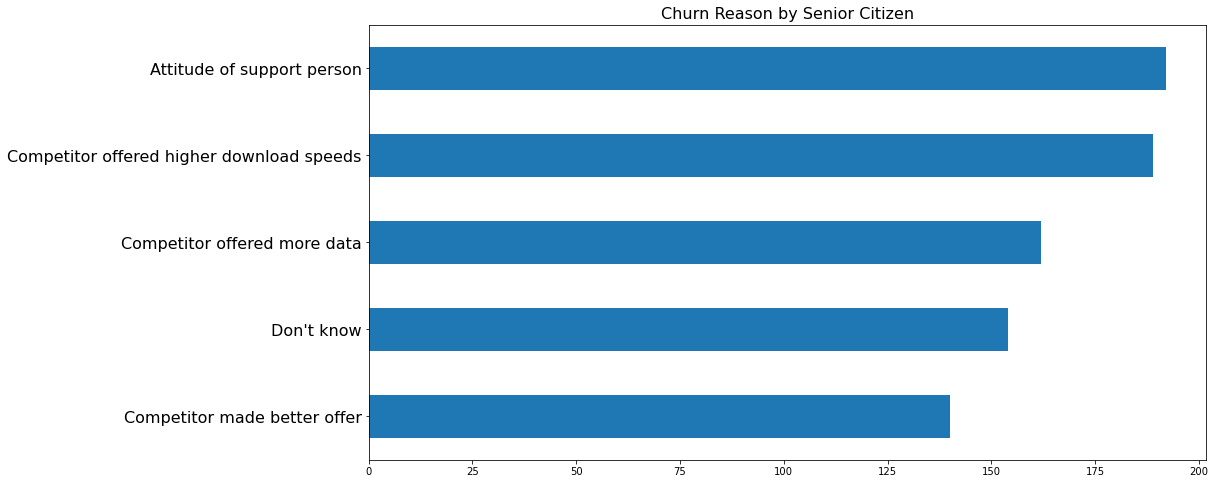

In [49]:
#churned senior citizen
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1)]['churn_reason'].value_counts(ascending=True).tail().plot(kind='barh')
plt.title('Churn Reason by Senior Citizen',fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('../images/churn_reason_senior_citizen.png')
plt.show()

As we look into the senior citizen's reason of churn is mostly driven by sales support attitude, where second comes the download speeds, third if external factor by competitors offer. 

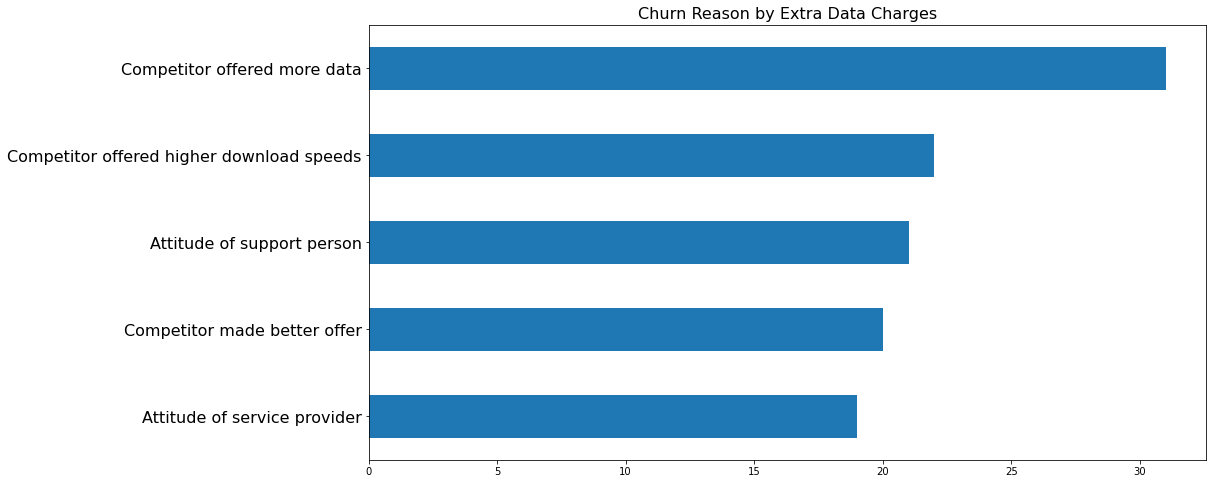

In [50]:
#churn extra data
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1) & (telco.total_extra_data_charges > 1)]['churn_reason'].value_counts(ascending=True).tail().plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('Churn Reason by Extra Data Charges',fontsize=16)
plt.savefig('../images/churn_reason_extra_data_charges.png')
plt.show()

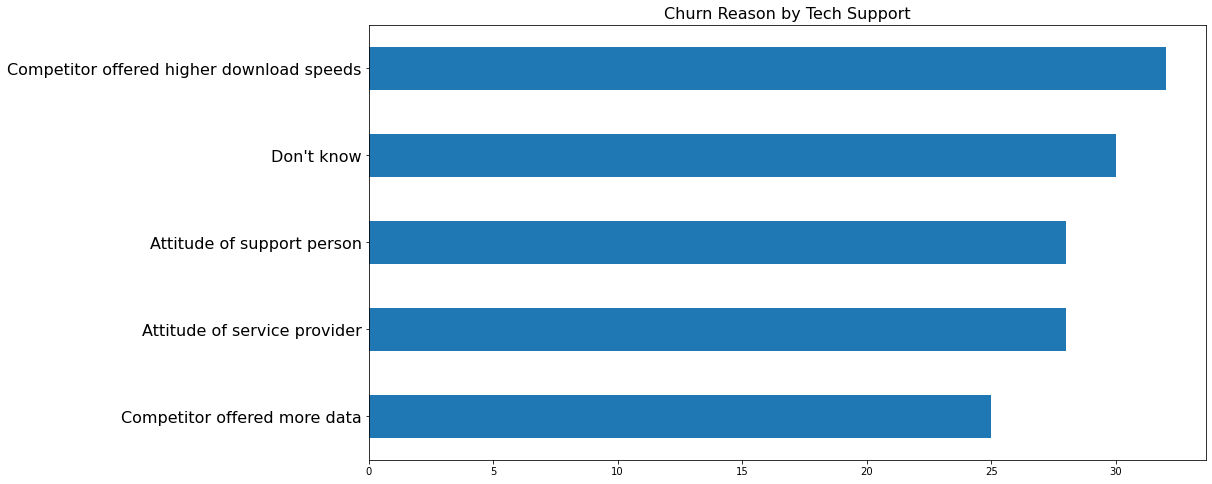

In [51]:
#churn tech support
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1) & (telco.tech_support == 1)]['churn_reason'].value_counts(ascending=True).tail().plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('Churn Reason by Tech Support',fontsize=16)
plt.savefig('../images/churn_reason_tech_support.png')
plt.show()

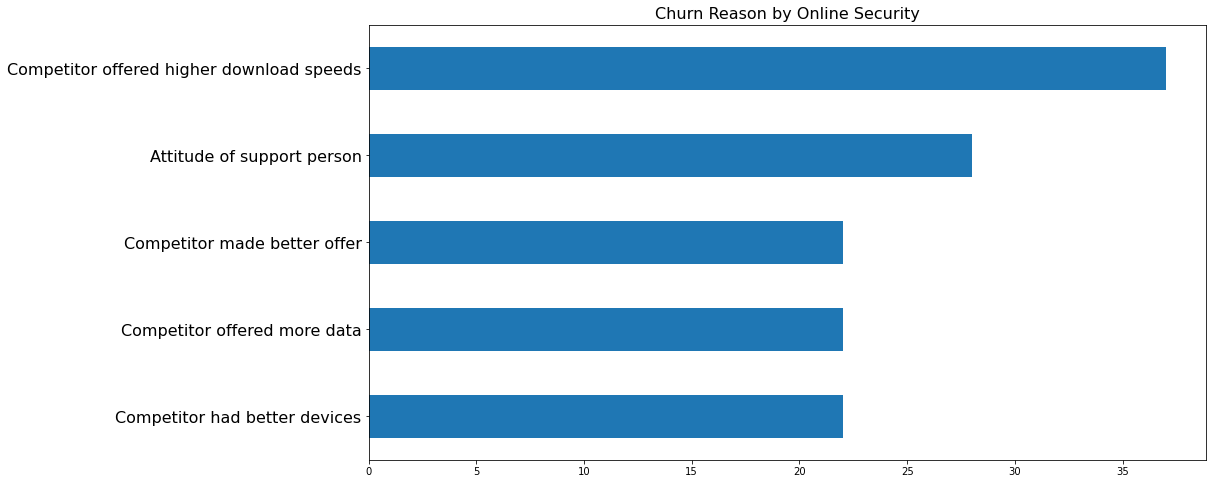

In [52]:
#churn online security
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1) & (telco.online_security == 1)]['churn_reason'].value_counts(ascending=True).tail().plot(kind='barh')
plt.yticks(fontsize=16)
plt.title('Churn Reason by Online Security',fontsize=16)
plt.savefig('../images/churn_reason_online_security.png')
plt.show()

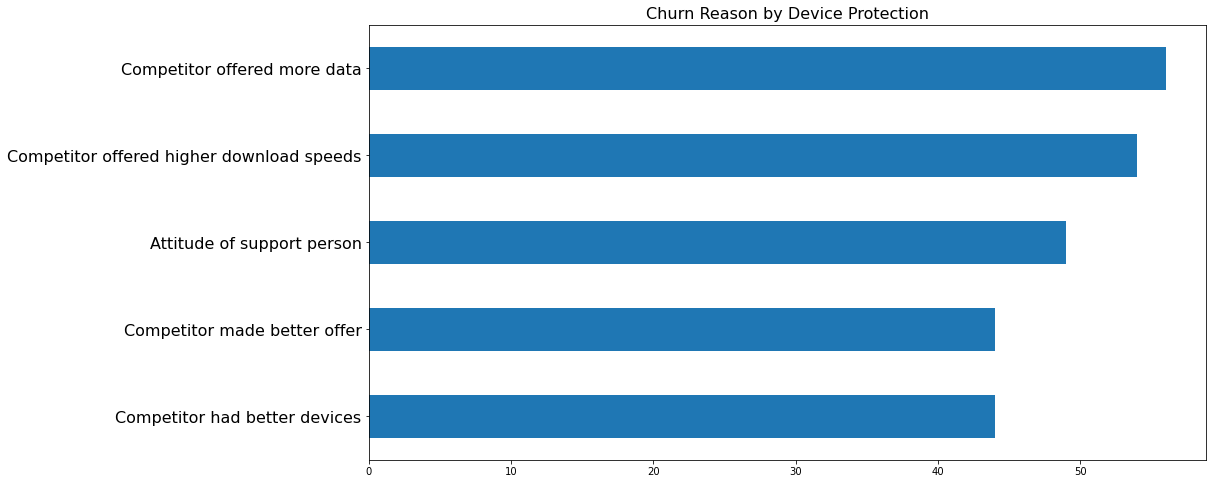

In [53]:
#churn device protection
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1) & (telco.device_protection == 1)]['churn_reason'].value_counts(ascending=True).tail().plot(kind='barh')
plt.title('Churn Reason by Device Protection',fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('../images/churn_reason_device_protection.png')
plt.show()

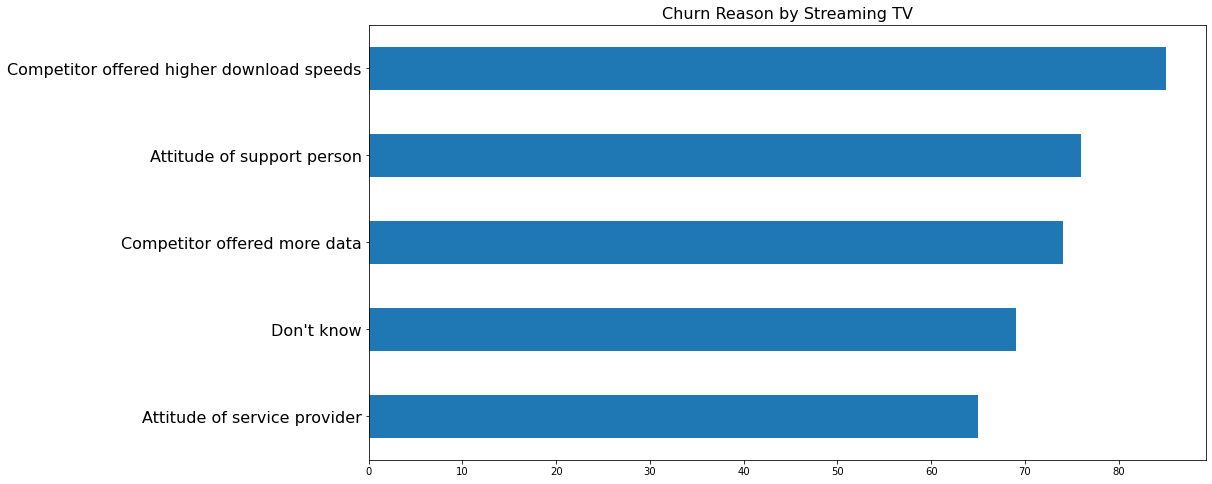

In [54]:
#churn streaming TV/ Movies/Music
plt.figure(figsize=(15,8))
telco[(telco.customer_status == 1) & (telco.streaming_tv == 1)]['churn_reason'].value_counts(ascending=True).tail().plot(kind='barh')
plt.title('Churn Reason by Streaming TV',fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('../images/churn_reason_streaming.png')
plt.show()

From above barplots of the highest count in churn reasons of different features, we observed the following

1. `senior_citizen` prioritized the attitude of the support person.

2. `total_extra_data_charges` shown that the churn reasons are because competitors have offered more data, higher download speeds and better offer.  

3. `tech_support` services users feedback on the attitude of service provider and support person.

4. On the other internet offers, the `online_security` has competition with churn reason being competitor offered better devices.

5. While for `device_protection`, similiarly indication that competitors had made better offers and better devices.

6. On the streaming services like `streaming_tv`, `streaming_movies` and `streaming_music`, customers that churned relayed where competitors offered higher download speed with more data. 

All in all, subscription services will require attentive support person and after sales while data related services requires improvement on the data and download speeds. 

In the next notebook 3.0, we will move into clustering for customer segmentation. 